# SimCLR Fine-tuning for Symbol Recognition

Fine-tunes SimCLR (from [sthalles/SimCLR](https://github.com/sthalles/SimCLR)) on the Bobyard symbol dataset.

**Approach:**
- Use the repo's `ResNetSimCLR` model architecture and `info_nce_loss`
- Load a pretrained SimCLR checkpoint (ResNet-18 trained on STL10 with contrastive learning)
- Fine-tune on cropped symbol patches using the same contrastive objective
- Use `UniqueClassBatchSampler` to ensure zero same-class collisions per batch (batch_size=32, 42 classes)
- Evaluate via k-NN on learned embeddings (1-shot and 5-shot)

In [ ]:
import json
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

from dataset import SymbolDataset, get_simclr_transform, get_eval_transform, get_class_distribution
from simclr_model import create_simclr_model, get_features
from train import run_experiment, EXPERIMENTS
from evaluate import extract_embeddings, few_shot_evaluate, full_evaluate

DATA_DIR = "data"
OUTPUT_DIR = "experiments"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

# Set to True to re-train from scratch, False to load saved checkpoints
RUN_TRAINING = False

## 1. Dataset Exploration

In [2]:
# Load dataset and inspect
train_ds = SymbolDataset(DATA_DIR, split="train", transform=get_eval_transform(64))
valid_ds = SymbolDataset(DATA_DIR, split="valid", transform=get_eval_transform(64))
test_ds = SymbolDataset(DATA_DIR, split="test", transform=get_eval_transform(64))

print(f"Train: {len(train_ds)} crops, Valid: {len(valid_ds)} crops, Test: {len(test_ds)} crops")
print(f"Number of symbol classes: {train_ds.num_classes}")

Train: 2606 crops, Valid: 755 crops, Test: 424 crops
Number of symbol classes: 42


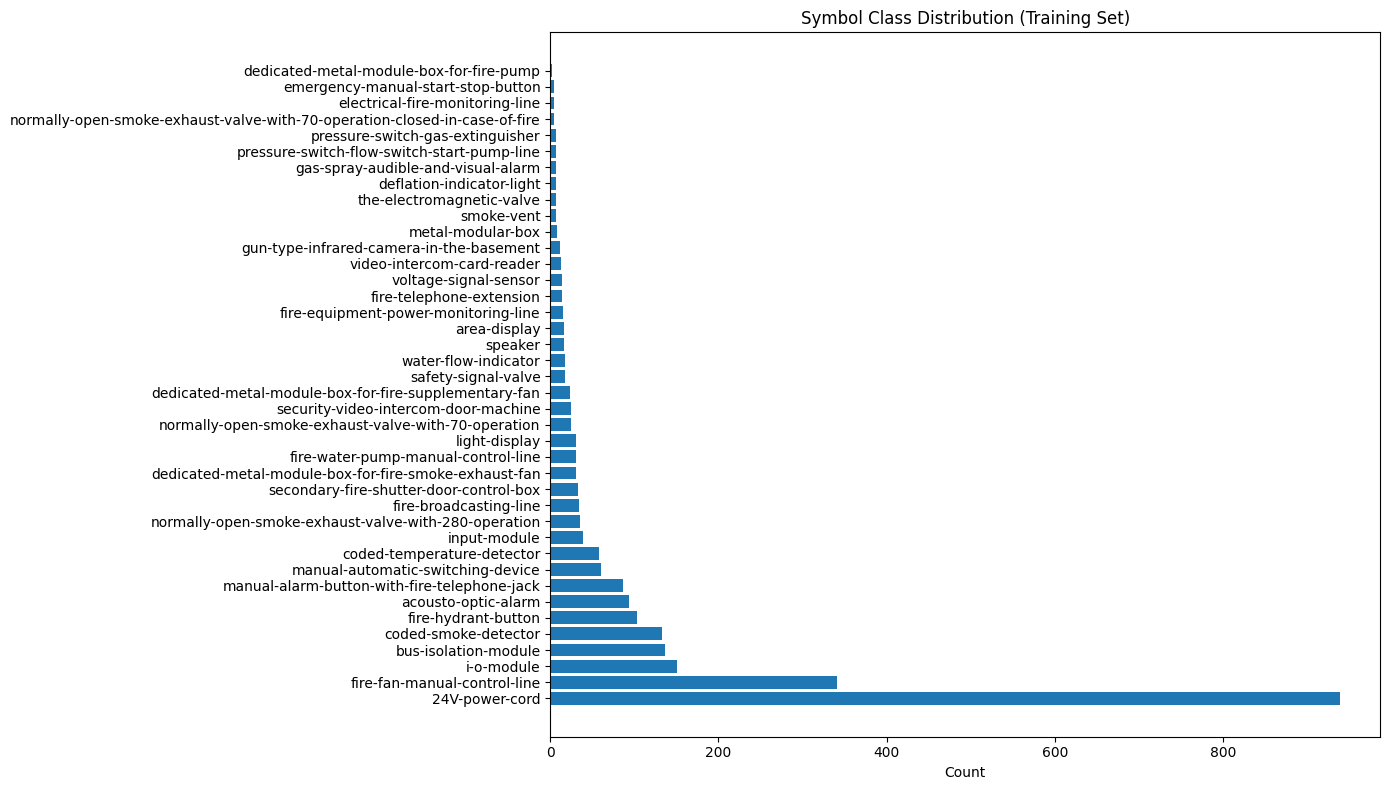

In [3]:
# Plot class distribution
dist = get_class_distribution(train_ds)
names = [train_ds.label_to_name[i] for i in sorted(dist.keys())]
counts = [dist[i] for i in sorted(dist.keys())]

fig, ax = plt.subplots(figsize=(14, 8))
sorted_idx = np.argsort(counts)[::-1]
ax.barh([names[i] for i in sorted_idx], [counts[i] for i in sorted_idx])
ax.set_xlabel("Count")
ax.set_title("Symbol Class Distribution (Training Set)")
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

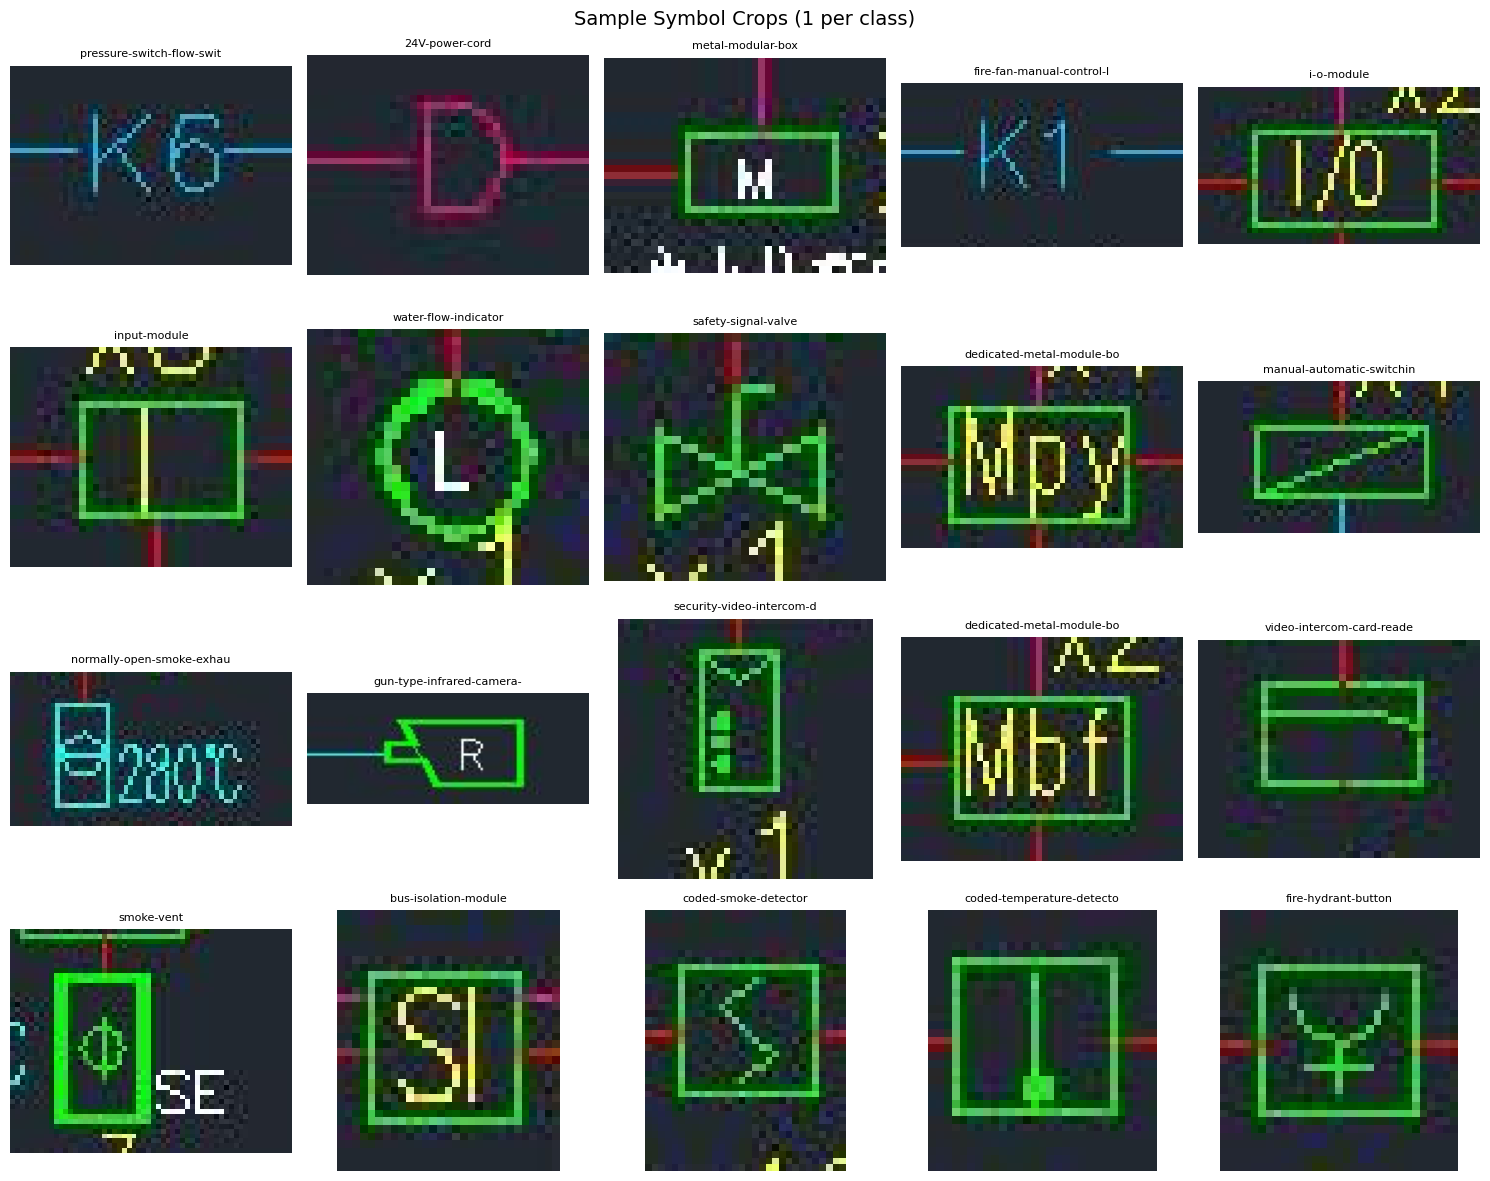

In [4]:
# Visualize sample symbol crops
raw_ds = SymbolDataset(DATA_DIR, split="train", transform=None)

# Show one sample per class (first 20 classes)
seen_classes = set()
samples_to_show = []
for img_path, bbox, label in raw_ds.samples:
    if label not in seen_classes and len(seen_classes) < 20:
        crop = raw_ds._crop_symbol(img_path, bbox)
        samples_to_show.append((crop, raw_ds.label_to_name[label]))
        seen_classes.add(label)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for idx, (crop, name) in enumerate(samples_to_show):
    ax = axes[idx // 5][idx % 5]
    ax.imshow(crop)
    ax.set_title(name[:25], fontsize=8)
    ax.axis("off")
plt.suptitle("Sample Symbol Crops (1 per class)", fontsize=14)
plt.tight_layout()
plt.savefig("sample_symbols.png", dpi=150, bbox_inches="tight")
plt.show()

## 2. Run Experiments

Fine-tune SimCLR with different hyperparameter configurations (all img_size=224, batch_size=32, unique classes per batch):
- **baseline**: temp=0.07, cosine LR scheduler, wd=1e-4
- **high_temp**: temp=0.5 (softer contrastive loss)
- **low_temp**: temp=0.01 (harder contrastive loss)
- **strong_aug**: aug_strength=1.5 (stronger augmentations)
- **no_scheduler**: constant LR (no decay)
- **high_wd**: weight_decay=1e-3 (stronger regularization)
- **low_wd**: weight_decay=1e-5 (weaker regularization)

In [5]:
Path(OUTPUT_DIR).mkdir(exist_ok=True)

all_histories = {}
all_models = {}

exp_names = ["baseline", "high_temp", "low_temp", "strong_aug",
             "no_scheduler", "high_wd", "low_wd"]

if RUN_TRAINING:
    for exp_name in exp_names:
        config = EXPERIMENTS[exp_name]
        history, model = run_experiment(config, DATA_DIR, OUTPUT_DIR, DEVICE)
        all_histories[exp_name] = history
        all_models[exp_name] = model
else:
    for exp_name in exp_names:
        config = EXPERIMENTS[exp_name]
        hist_path = Path(OUTPUT_DIR) / exp_name / "history.json"
        with open(hist_path) as f:
            all_histories[exp_name] = json.load(f)
        ckpt_path = Path(OUTPUT_DIR) / exp_name / f"checkpoint_{config['epochs']:04d}.pth.tar"
        model = create_simclr_model(
            base_model=config["backbone"],
            out_dim=config.get("out_dim", 128),
            checkpoint_path=str(ckpt_path),
        ).to(DEVICE)
        all_models[exp_name] = model
        print(f"Loaded {exp_name}")

/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained SimCLR checkpoint from experiments/baseline/checkpoint_0050.pth.tar
  arch=resnet18, epoch=50, keys=124


Loaded baseline


Loaded pretrained SimCLR checkpoint from experiments/high_temp/checkpoint_0050.pth.tar
  arch=resnet18, epoch=50, keys=124
Loaded high_temp


Loaded pretrained SimCLR checkpoint from experiments/low_temp/checkpoint_0050.pth.tar
  arch=resnet18, epoch=50, keys=124
Loaded low_temp


Loaded pretrained SimCLR checkpoint from experiments/strong_aug/checkpoint_0050.pth.tar
  arch=resnet18, epoch=50, keys=124
Loaded strong_aug


Loaded pretrained SimCLR checkpoint from experiments/no_scheduler/checkpoint_0050.pth.tar
  arch=resnet18, epoch=50, keys=124
Loaded no_scheduler


Loaded pretrained SimCLR checkpoint from experiments/high_wd/checkpoint_0050.pth.tar
  arch=resnet18, epoch=50, keys=124
Loaded high_wd


Loaded pretrained SimCLR checkpoint from experiments/low_wd/checkpoint_0050.pth.tar
  arch=resnet18, epoch=50, keys=124
Loaded low_wd


## 3. Training Loss Curves

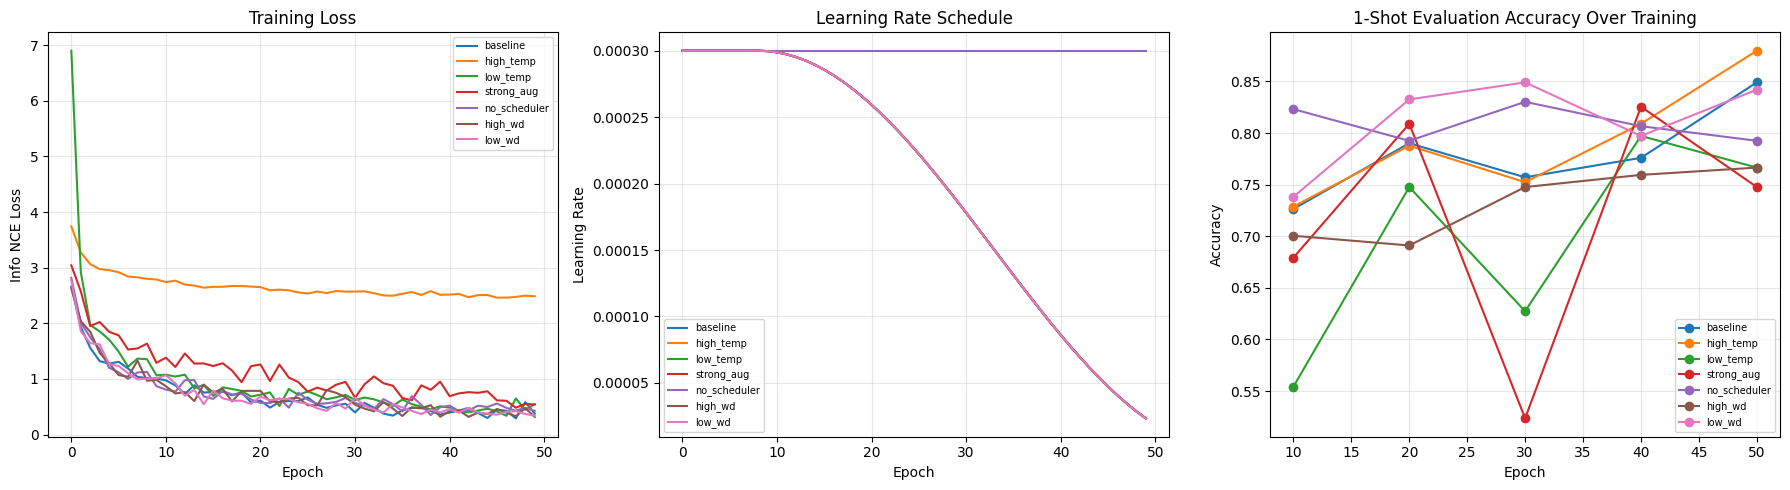

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
ax = axes[0]
for exp_name, hist in all_histories.items():
    ax.plot(hist["loss"], label=exp_name)
ax.set_xlabel("Epoch")
ax.set_ylabel("Info NCE Loss")
ax.set_title("Training Loss")
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# LR schedule comparison
ax = axes[1]
for exp_name, hist in all_histories.items():
    ax.plot(hist["lr"], label=exp_name)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax.set_title("Learning Rate Schedule")
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# Few-shot accuracy over training
ax = axes[2]
for exp_name, hist in all_histories.items():
    if hist["eval_1shot"]:
        epochs = [e["epoch"] for e in hist["eval_1shot"]]
        accs = [e["accuracy"] for e in hist["eval_1shot"]]
        ax.plot(epochs, accs, marker="o", label=exp_name)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("1-Shot Evaluation Accuracy Over Training")
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Final Evaluation Comparison

/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


baseline        | 1-shot: 0.7854 | 5-shot: 0.8939 | full: 0.9929


/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


high_temp       | 1-shot: 0.7972 | 5-shot: 0.9127 | full: 0.9906


/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


low_temp        | 1-shot: 0.7783 | 5-shot: 0.8750 | full: 0.9929


/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


strong_aug      | 1-shot: 0.7759 | 5-shot: 0.8679 | full: 0.9929


/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


no_scheduler    | 1-shot: 0.8538 | 5-shot: 0.8915 | full: 0.9929


/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


high_wd         | 1-shot: 0.7524 | 5-shot: 0.8892 | full: 0.9929


/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


low_wd          | 1-shot: 0.8019 | 5-shot: 0.9057 | full: 0.9929


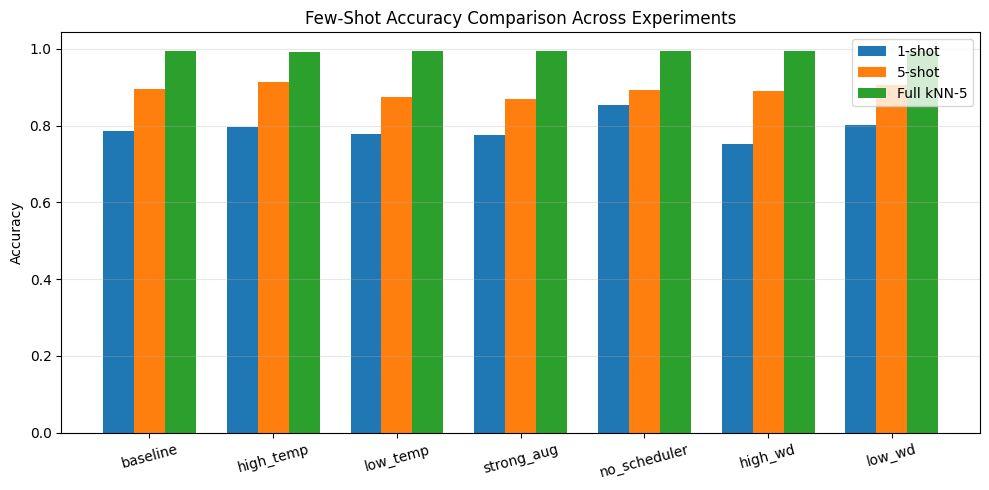

In [7]:
# Compare final accuracy across experiments
results_summary = []

for exp_name, model in all_models.items():
    config = EXPERIMENTS[exp_name]
    img_size = config.get("img_size", 64)

    r1 = few_shot_evaluate(model, DATA_DIR, DEVICE, img_size, n_shots=1, k_neighbors=1)
    r5 = few_shot_evaluate(model, DATA_DIR, DEVICE, img_size, n_shots=5, k_neighbors=3)
    r_full = full_evaluate(model, DATA_DIR, DEVICE, img_size)

    results_summary.append({
        "experiment": exp_name,
        "1-shot": r1["accuracy"],
        "5-shot": r5["accuracy"],
        "full (kNN-5)": r_full["accuracy"],
    })
    print(f"{exp_name:15s} | 1-shot: {r1['accuracy']:.4f} | 5-shot: {r5['accuracy']:.4f} | full: {r_full['accuracy']:.4f}")

# Bar chart
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(results_summary))
w = 0.25
ax.bar(x - w, [r["1-shot"] for r in results_summary], w, label="1-shot")
ax.bar(x, [r["5-shot"] for r in results_summary], w, label="5-shot")
ax.bar(x + w, [r["full (kNN-5)"] for r in results_summary], w, label="Full kNN-5")
ax.set_xticks(x)
ax.set_xticklabels([r["experiment"] for r in results_summary], rotation=15)
ax.set_ylabel("Accuracy")
ax.set_title("Few-Shot Accuracy Comparison Across Experiments")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. t-SNE Embedding Visualization

Best model: no_scheduler (1-shot acc: 0.8538)


Embeddings shape: (424, 512)


/tmp/ipykernel_1806079/1866170951.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(top_labels))


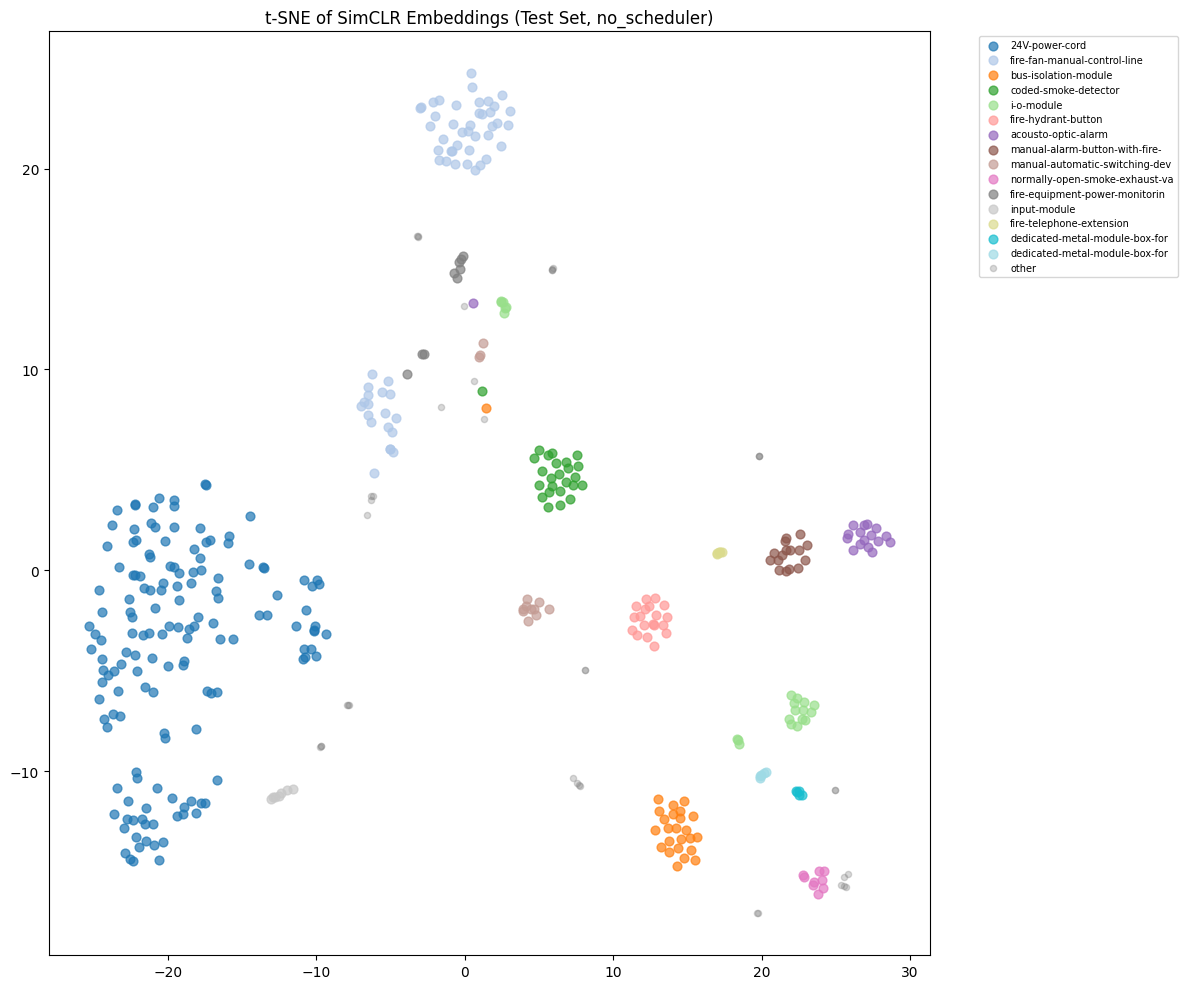

In [8]:
# Find best model based on 1-shot accuracy
best_exp = max(results_summary, key=lambda r: r["1-shot"])
best_name = best_exp["experiment"]
best_model = all_models[best_name]
best_img_size = EXPERIMENTS[best_name].get("img_size", 64)
print(f"Best model: {best_name} (1-shot acc: {best_exp['1-shot']:.4f})")

# Extract embeddings from test set
eval_transform = get_eval_transform(best_img_size)
test_ds_eval = SymbolDataset(DATA_DIR, split="test", transform=eval_transform)
test_loader = DataLoader(test_ds_eval, batch_size=128, shuffle=False, num_workers=4)

embeddings, labels = extract_embeddings(best_model, test_loader, DEVICE)
print(f"Embeddings shape: {embeddings.shape}")

# t-SNE
perplexity = min(30, len(embeddings) - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

# Plot - color by class, show top-15 classes for readability
label_counts = Counter(labels)
top_labels = [l for l, _ in label_counts.most_common(15)]

fig, ax = plt.subplots(figsize=(12, 10))
cmap = plt.cm.get_cmap("tab20", len(top_labels))

for i, lbl in enumerate(top_labels):
    mask = labels == lbl
    name = test_ds_eval.label_to_name.get(lbl, str(lbl))
    ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c=[cmap(i)], label=name[:30], s=40, alpha=0.7)

# Plot remaining classes in gray
other_mask = ~np.isin(labels, top_labels)
if other_mask.sum() > 0:
    ax.scatter(emb_2d[other_mask, 0], emb_2d[other_mask, 1], c="gray", label="other", s=20, alpha=0.3)

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=7)
ax.set_title(f"t-SNE of SimCLR Embeddings (Test Set, {best_name})")
plt.tight_layout()
plt.savefig("tsne_embeddings.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Baseline Comparison: Pretrained (no fine-tuning) vs Fine-tuned

/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained SimCLR checkpoint from /mnt/SSD4/yuanyi/practise/Bobyard/pretrained/simclr_stl10/checkpoint_0100.pth.tar
  arch=resnet18, epoch=100, keys=124


/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


/mnt/SSD4/yuanyi/practise/Bobyard/.venv/lib/python3.11/site-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


Model                              1-shot     5-shot
----------------------------------------------------
SimCLR Pretrained (STL10)          0.3561     0.6651
SimCLR Fine-tuned (no_scheduler)     0.7783     0.8585


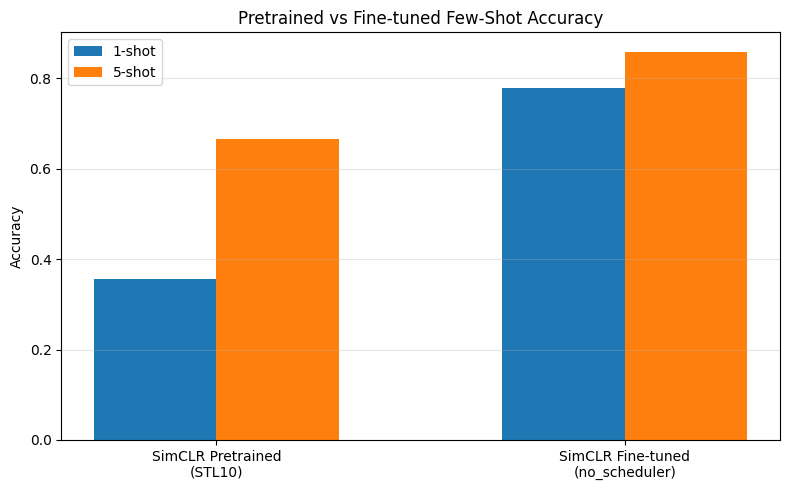

In [9]:
# Compare: SimCLR pretrained on STL10 (no fine-tuning) vs fine-tuned on symbols
pretrained_model = create_simclr_model(base_model="resnet18").to(DEVICE)

r_pretrained_1 = few_shot_evaluate(pretrained_model, DATA_DIR, DEVICE, 64, n_shots=1, k_neighbors=1)
r_pretrained_5 = few_shot_evaluate(pretrained_model, DATA_DIR, DEVICE, 64, n_shots=5, k_neighbors=3)

r_finetuned_1 = few_shot_evaluate(best_model, DATA_DIR, DEVICE, best_img_size, n_shots=1, k_neighbors=1)
r_finetuned_5 = few_shot_evaluate(best_model, DATA_DIR, DEVICE, best_img_size, n_shots=5, k_neighbors=3)

print(f"{'Model':<30} {'1-shot':>10} {'5-shot':>10}")
print("-" * 52)
print(f"{'SimCLR Pretrained (STL10)':<30} {r_pretrained_1['accuracy']:>10.4f} {r_pretrained_5['accuracy']:>10.4f}")
print(f"{'SimCLR Fine-tuned ('+best_name+')':<30} {r_finetuned_1['accuracy']:>10.4f} {r_finetuned_5['accuracy']:>10.4f}")

# Bar chart comparison
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(2)
w = 0.3
ax.bar(x - w/2, [r_pretrained_1["accuracy"], r_finetuned_1["accuracy"]], w, label="1-shot")
ax.bar(x + w/2, [r_pretrained_5["accuracy"], r_finetuned_5["accuracy"]], w, label="5-shot")
ax.set_xticks(x)
ax.set_xticklabels(["SimCLR Pretrained\n(STL10)", f"SimCLR Fine-tuned\n({best_name})"])
ax.set_ylabel("Accuracy")
ax.set_title("Pretrained vs Fine-tuned Few-Shot Accuracy")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig("pretrained_vs_finetuned.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Summary

In [10]:
print("=" * 80)
print("EXPERIMENT SUMMARY")
print("=" * 80)
print(f"\nDataset: {len(train_ds)} train / {len(valid_ds)} valid / {len(test_ds)} test crops")
print(f"Classes: {train_ds.num_classes}")
print(f"Batch size: 32 (unique classes per batch, zero same-class collisions)")
print(f"Pretrained checkpoint: SimCLR ResNet-18, 100 epochs on STL10")
print(f"\n{'Experiment':<15} {'Temp':>6} {'ImgSize':>8} {'AugStr':>7} {'LR Sched':>10} {'WD':>10} {'1-shot':>10} {'5-shot':>10} {'Full kNN-5':>12}")
print("-" * 90)
for r in results_summary:
    cfg = EXPERIMENTS[r['experiment']]
    lr_sched = cfg.get('lr_scheduler', 'cosine')
    wd = cfg.get('weight_decay', 1e-4)
    print(f"{r['experiment']:<15} {cfg['temperature']:>6.2f} {cfg['img_size']:>8} {cfg['aug_strength']:>7.1f} "
          f"{lr_sched:>10} {wd:>10.0e} "
          f"{r['1-shot']:>10.4f} {r['5-shot']:>10.4f} {r['full (kNN-5)']:>12.4f}")
print(f"\nBest model: {best_name} (1-shot: {best_exp['1-shot']:.4f})")
print(f"\nFine-tuning improvement over pretrained baseline:")
print(f"  1-shot: {r_pretrained_1['accuracy']:.4f} -> {r_finetuned_1['accuracy']:.4f} "
      f"(+{r_finetuned_1['accuracy'] - r_pretrained_1['accuracy']:.4f})")
print(f"  5-shot: {r_pretrained_5['accuracy']:.4f} -> {r_finetuned_5['accuracy']:.4f} "
      f"(+{r_finetuned_5['accuracy'] - r_pretrained_5['accuracy']:.4f})")

EXPERIMENT SUMMARY

Dataset: 2606 train / 755 valid / 424 test crops
Classes: 42
Batch size: 32 (unique classes per batch, zero same-class collisions)
Pretrained checkpoint: SimCLR ResNet-18, 100 epochs on STL10

Experiment        Temp  ImgSize  AugStr   LR Sched         WD     1-shot     5-shot   Full kNN-5
------------------------------------------------------------------------------------------
baseline          0.07      224     1.0     cosine      1e-04     0.7854     0.8939       0.9929
high_temp         0.50      224     1.0     cosine      1e-04     0.7972     0.9127       0.9906
low_temp          0.01      224     1.0     cosine      1e-04     0.7783     0.8750       0.9929
strong_aug        0.07      224     1.5     cosine      1e-04     0.7759     0.8679       0.9929
no_scheduler      0.07      224     1.0       none      1e-04     0.8538     0.8915       0.9929
high_wd           0.07      224     1.0     cosine      1e-03     0.7524     0.8892       0.9929
low_wd           